In [1]:
import pandas as pd

In [52]:
uselog = pd.read_csv("data/4章/use_log.csv")

In [53]:
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [54]:
customer = pd.read_csv("data/4章/customer_join.csv")

In [55]:
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [56]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]

In [57]:
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [58]:
from sklearn.cluster import KMeans

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [61]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[1 2 3 0]


/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [62]:
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,841,841,841,841,841
1,1248,1248,1248,1248,1248
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [63]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061076,8.046373,10.015458,6.171225,7.027348
1,4.677436,4.671074,7.233173,2.153045,36.925481
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.537658,5.388889,8.753754,2.702703,14.876126


In [64]:
from sklearn.decomposition import PCA

In [65]:
X = customer_clustering_sc

In [66]:
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

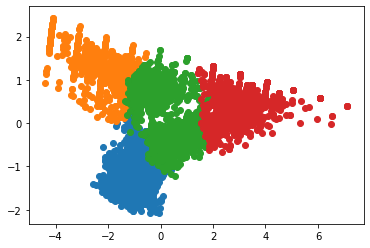

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [68]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)

In [69]:
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,822
1,0,1,19
2,1,0,1230
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [70]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,789
2,1,0,2
3,1,1,1246
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [71]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])

In [72]:
uselog["年月"] = uselog["usedate"].dt.strftime("%Y/%m")

In [73]:
uselog_months = uselog.groupby(["年月", "customer_id"], as_index=False).count()

In [74]:
uselog_months.rename(columns={"log_id":"count"}, inplace=True)

In [75]:
del uselog_months["usedate"]

In [76]:
uselog_months.head()

,年月,customer_id,count
0,2018/04,AS002855,4
1,2018/04,AS009013,2
2,2018/04,AS009373,3
3,2018/04,AS015315,6
4,2018/04,AS015739,7


In [77]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()

In [78]:
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018/10,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,2018/10,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [79]:
predict_data = predict_data.dropna()

In [80]:
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,2018/10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,2018/10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [81]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")

In [82]:
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,2018/10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,2018/10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [83]:
predict_data["年月"] = pd.to_datetime(predict_data["年月"]).dt.strftime("%Y%m")

In [84]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")

In [85]:
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

In [86]:
from dateutil.relativedelta import relativedelta

In [87]:
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [88]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]

In [89]:
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()

In [90]:
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6040426436232018
0.6167191858326159


In [92]:
coef = pd.DataFrame({"feature_name":X.columns, "coefficient":model.coef_})
coef

,feature_name,coefficient
0,count_0,0.334850
1,count_1,0.195361
2,count_2,0.168565
3,count_3,0.181755
4,count_4,0.071157
5,count_5,0.070687
6,period,0.017017


In [ ]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1,x2]